In [2]:
import datetime
import math
import openai
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from dotenv import load_dotenv


# Load environment variables for OpenAI API
load_dotenv()
openai.api_key = os.getenv('OPENAI_API_KEY')

# 3.1 Editing Traditional AIMD

## 3.1.1 Standard AIMD

Number of iterations to converge: 158
Final x1: 25.00
Final x2: 25.00


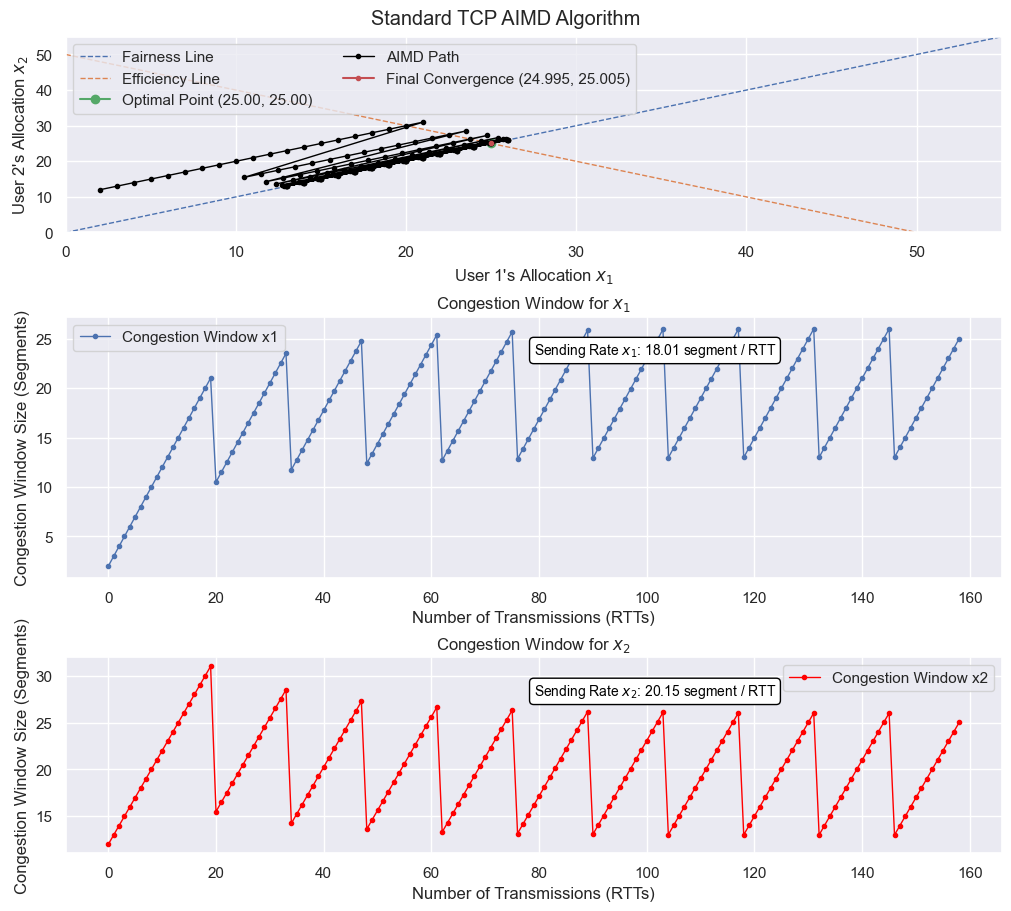

In [54]:
def aimd_convergence_plot(C, x1, x2, alpha1, alpha2, beta1, beta2, output: str = 'output.svg', title: str = 'AIMD Convergence Algorithm'):
    """
    Visualizes the AIMD (Additive Increase Multiplicative Decrease) process.

    Args:
        C (int): Maximum capacity before multiplicative decrease is applied.
        x1 (int): Initial allocation for user 1.
        x2 (int): Initial allocation for user 2.
        alpha1 (int): Additive increase factor for x1.
        alpha2 (int): Additive increase factor for x2.
        beta1 (int): Multiplicative decrease factor for x1.
        beta2 (int): Multiplicative decrease factor for x2.
        output (str): Filename to save the plot (default: 'output.svg').
        title (str): Main title of the plot.
    """

    # Apply Seaborn dark grid theme
    sns.set_theme(style="darkgrid")

    # Initialize lists to store allocations
    x1_values, x2_values = [x1], [x2]
    
    # Compute the optimal point of convergence
    optimal_x = C / 2
    optimal_y = C / 2

    iterations = 0

    while iterations < 1000:  # Prevent infinite loops
        if round(x1, 2) == round(optimal_x, 2) and round(x2, 2) == round(optimal_y, 2):
            break

        # Apply Additive Increase if sum is within capacity
        if (x1 + x2) <= C:
            x1 += alpha1
            x2 += alpha2
        else:  # Apply Multiplicative Decrease if sum exceeds capacity
            x1 *= (1 - beta1)
            x2 *= (1 - beta2)

        x1_values.append(x1)
        x2_values.append(x2)
        iterations += 1

    # Convert lists to NumPy arrays for easier plotting
    x1_values, x2_values = np.array(x1_values), np.array(x2_values)

    # Compute average sending rates
    sending_rate_x1 = np.mean(x1_values)
    sending_rate_x2 = np.mean(x2_values)

    print(f'Number of iterations to converge: {iterations}')
    print(f'Final x1: {x1:.2f}')
    print(f'Final x2: {x2:.2f}')

    # Adjust figure layout to make congestion graphs bigger
    fig = plt.figure(figsize=(10, 9), layout="constrained")  # Increased figure size

    # Create subplots with adjusted row spans for bigger congestion graphs
    main_plot = plt.subplot2grid((10, 2), (0, 0), colspan=2, rowspan=3)  # Reduced height of main plot
    congestion_x1 = plt.subplot2grid((10, 2), (3, 0), colspan=2, rowspan=4)  # Increased height
    congestion_x2 = plt.subplot2grid((10, 2), (7, 0), colspan=2, rowspan=3)  # Increased height

    # Fairness Line (x1 = x2)
    fairness_x = np.linspace(0, C * 1.1, C)
    main_plot.plot(fairness_x, fairness_x, linestyle='dashed', linewidth=1, label='Fairness Line')

    # Efficiency Line (x1 + x2 = C)
    efficiency_x = np.linspace(0, C, C)
    efficiency_y = C - efficiency_x
    main_plot.plot(efficiency_x, efficiency_y, linestyle='dashed', linewidth=1, label='Efficiency Line')

    # Optimal Point
    main_plot.plot(optimal_x, optimal_y, marker='o', label=f'Optimal Point ({optimal_x:.2f}, {optimal_y:.2f})')

    # AIMD Algorithm Trajectory
    main_plot.plot(x1_values, x2_values, marker='.', color='black', linewidth=1, label='AIMD Path')

    # Final Convergent Point
    main_plot.plot(x1_values[-1], x2_values[-1], marker='.', label=f'Final Convergence ({x1_values[-1]:.3f}, {x2_values[-1]:.3f})')

    # Labels & Formatting
    main_plot.set_xlabel("User 1's Allocation $x_{1}$")
    main_plot.set_ylabel("User 2's Allocation $x_{2}$")
    main_plot.set_xlim(0, C * 1.1)
    main_plot.set_ylim(0, C * 1.1)
    main_plot.legend(loc='upper left', ncol=2)

    # RTT (Round-Trip Time) values
    rtt_values = np.arange(iterations + 1)

    # Congestion Window for x1
    congestion_x1.plot(rtt_values, x1_values, marker=".", linewidth=1, label='Congestion Window x1')
    congestion_x1.annotate(
        f'Sending Rate $x_{1}$: {sending_rate_x1:.2f} segment / RTT',
        xy=(iterations / 2, np.max(x1_values) * 0.9),
        fontsize=10, color='black',
        bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3')
    )
    congestion_x1.set_xlabel('Number of Transmissions (RTTs)')
    congestion_x1.set_ylabel('Congestion Window Size (Segments)')
    congestion_x1.set_title('Congestion Window for $x_{1}$')
    congestion_x1.legend()

    # Congestion Window for x2
    congestion_x2.plot(rtt_values, x2_values, marker=".", linewidth=1, label='Congestion Window x2', color='red')
    congestion_x2.annotate(
        f'Sending Rate $x_{2}$: {sending_rate_x2:.2f} segment / RTT',
        xy=(iterations / 2, np.max(x2_values) * 0.9),
        fontsize=10, color='black',
        bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3')
    )
    congestion_x2.set_xlabel('Number of Transmissions (RTTs)')
    congestion_x2.set_ylabel('Congestion Window Size (Segments)')
    congestion_x2.set_title('Congestion Window for $x_{2}$')
    congestion_x2.legend()

    fig.suptitle(title)

    # Save and show the plot
    plt.savefig(output)
    plt.show()

aimd_convergence_plot(C=50,
        x1=2,
        x2=12,
        alpha1=1,
        alpha2=1,
        beta1=0.5,
        beta2=0.5,
        output=f"AIMD_Standard.svg",
        title="Standard TCP AIMD Algorithm"
        )

## 3.1.2 Logarithmic Increase Multiplicative Decrease (LIMD)

Number of iterations to converge: 126
Final x1: 25.00
Final x2: 25.00


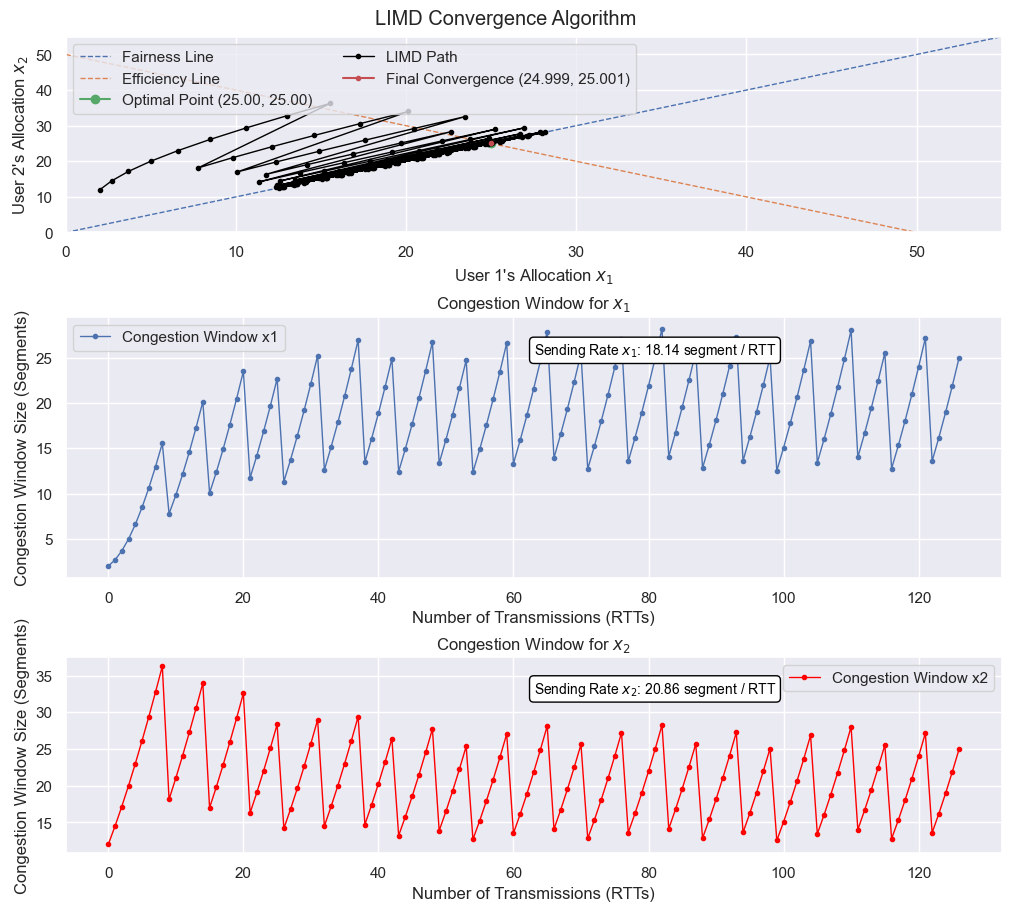

In [48]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def limd_convergence_plot(C, x1, x2, beta1, beta2, output: str = 'limd_output.svg', title: str = 'LIMD Convergence Algorithm'):
    """
    Visualizes the Logarithmic Increase Multiplicative Decrease (LIMD) process.

    Args:
        C (int): Maximum capacity before multiplicative decrease is applied.
        x1 (int): Initial allocation for user 1.
        x2 (int): Initial allocation for user 2.
        beta1 (float): Multiplicative decrease factor for x1.
        beta2 (float): Multiplicative decrease factor for x2.
        output (str): Filename to save the plot (default: 'limd_output.svg').
        title (str): Main title of the plot.
    """

    # Apply Seaborn dark grid theme
    sns.set_theme(style="darkgrid")

    # Initialize lists to store allocations
    x1_values, x2_values = [x1], [x2]
    
    # Compute the optimal point of convergence
    optimal_x = C / 2
    optimal_y = C / 2

    iterations = 0

    while iterations < 1000:  # Prevent infinite loops
        if round(x1, 2) == round(optimal_x, 2) and round(x2, 2) == round(optimal_y, 2):
            break

        # Apply Logarithmic Increase if sum is within capacity
        if (x1 + x2) <= C:
            x1 += np.log(x1)  # Logarithmic growth
            x2 += np.log(x2)  
        else:  # Apply Multiplicative Decrease if sum exceeds capacity
            x1 *= (1 - beta1)
            x2 *= (1 - beta2)

        x1_values.append(x1)
        x2_values.append(x2)
        iterations += 1

    # Convert lists to NumPy arrays for easier plotting
    x1_values, x2_values = np.array(x1_values), np.array(x2_values)

    # Compute average sending rates
    sending_rate_x1 = np.mean(x1_values)
    sending_rate_x2 = np.mean(x2_values)

    print(f'Number of iterations to converge: {iterations}')
    print(f'Final x1: {x1:.2f}')
    print(f'Final x2: {x2:.2f}')

    # Adjust figure layout to make congestion graphs bigger
    fig = plt.figure(figsize=(10, 9), layout="constrained")  # Increased figure size

    # Create subplots with adjusted row spans for bigger congestion graphs
    main_plot = plt.subplot2grid((10, 2), (0, 0), colspan=2, rowspan=3)  # Reduced height of main plot
    congestion_x1 = plt.subplot2grid((10, 2), (3, 0), colspan=2, rowspan=4)  # Increased height
    congestion_x2 = plt.subplot2grid((10, 2), (7, 0), colspan=2, rowspan=3)  # Increased height

    # Fairness Line (x1 = x2)
    fairness_x = np.linspace(0, C * 1.1, C)
    main_plot.plot(fairness_x, fairness_x, linestyle='dashed', linewidth=1, label='Fairness Line')

    # Efficiency Line (x1 + x2 = C)
    efficiency_x = np.linspace(0, C, C)
    efficiency_y = C - efficiency_x
    main_plot.plot(efficiency_x, efficiency_y, linestyle='dashed', linewidth=1, label='Efficiency Line')

    # Optimal Point
    main_plot.plot(optimal_x, optimal_y, marker='o', label=f'Optimal Point ({optimal_x:.2f}, {optimal_y:.2f})')

    # LIMD Algorithm Trajectory
    main_plot.plot(x1_values, x2_values, marker='.', color='black', linewidth=1, label='LIMD Path')

    # Final Convergent Point
    main_plot.plot(x1_values[-1], x2_values[-1], marker='.', label=f'Final Convergence ({x1_values[-1]:.3f}, {x2_values[-1]:.3f})')

    # Labels & Formatting
    main_plot.set_xlabel("User 1's Allocation $x_{1}$")
    main_plot.set_ylabel("User 2's Allocation $x_{2}$")
    main_plot.set_xlim(0, C * 1.1)
    main_plot.set_ylim(0, C * 1.1)
    main_plot.legend(loc='upper left', ncol=2)

    # RTT (Round-Trip Time) values
    rtt_values = np.arange(iterations + 1)

    # Congestion Window for x1
    congestion_x1.plot(rtt_values, x1_values, marker=".", linewidth=1, label='Congestion Window x1')
    congestion_x1.annotate(
        f'Sending Rate $x_{1}$: {sending_rate_x1:.2f} segment / RTT',
        xy=(iterations / 2, np.max(x1_values) * 0.9),
        fontsize=10, color='black',
        bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3')
    )
    congestion_x1.set_xlabel('Number of Transmissions (RTTs)')
    congestion_x1.set_ylabel('Congestion Window Size (Segments)')
    congestion_x1.set_title('Congestion Window for $x_{1}$')
    congestion_x1.legend()

    # Congestion Window for x2
    congestion_x2.plot(rtt_values, x2_values, marker=".", linewidth=1, label='Congestion Window x2', color='red')
    congestion_x2.annotate(
        f'Sending Rate $x_{2}$: {sending_rate_x2:.2f} segment / RTT',
        xy=(iterations / 2, np.max(x2_values) * 0.9),
        fontsize=10, color='black',
        bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3')
    )
    congestion_x2.set_xlabel('Number of Transmissions (RTTs)')
    congestion_x2.set_ylabel('Congestion Window Size (Segments)')
    congestion_x2.set_title('Congestion Window for $x_{2}$')
    congestion_x2.legend()

    fig.suptitle(title)

    # Save and show the plot
    plt.savefig(output)
    plt.show()

limd_convergence_plot(C=50,
          x1=2,
          x2=12,
          beta1=0.5,
          beta2=0.5,
          output=f"LIMD.svg",
          title="LIMD Convergence Algorithm"
          )

In [51]:
def perron_frobenius_right_eigenvector(matrix):
    """
    Calculate the Perron-Frobenius right eigenvector of a non-negative square matrix.
    """
    eigenvalues, eigenvectors = np.linalg.eig(matrix)
    max_eigenvalue_index = np.argmax(np.real(eigenvalues))
    perron_frobenius_eigenvector = np.real(eigenvectors[:, max_eigenvalue_index])
    perron_frobenius_eigenvector /= np.sum(perron_frobenius_eigenvector)
    return perron_frobenius_eigenvector

# Define the LIMD transition matrix
betas = np.array([[0.5, 0.5]])  # Multiplicative Decrease Factors
window_sizes = np.array([[2], [12]])  # Initial Window Sizes
log_window = np.log(window_sizes)

A = np.array([[betas[0][0], 0], [0, betas[0][1]]]) + (1 / np.sum(log_window) * (np.dot(log_window, (1 - betas))))

# Compute dominant eigenvector
pf_eigenvector = perron_frobenius_right_eigenvector(A)
print("Perron-Frobenius Eigenvector:", pf_eigenvector)


Perron-Frobenius Eigenvector: [0.21810429 0.78189571]


## 3.1.3 Additive Increase Logarithmic Decrease (AILD)

Number of iterations to converge: 839
Final x1: 25.00
Final x2: 25.00


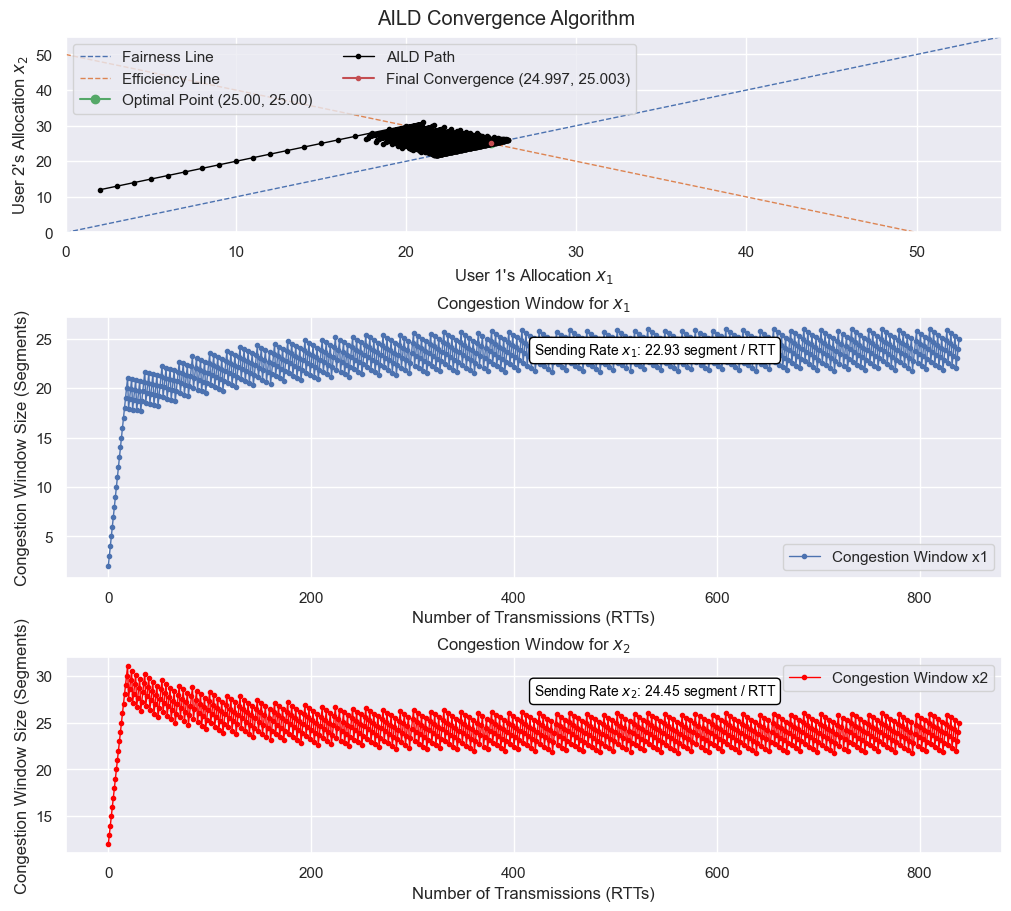

In [41]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def aild_convergence_plot(C, x1, x2, alpha1, alpha2, output: str = 'aild_output.svg', title: str = 'AILD Convergence Algorithm'):
    """
    Visualizes the Additive Increase Logarithmic Decrease (AILD) process.

    Args:
        C (int): Maximum capacity before logarithmic decrease is applied.
        x1 (int): Initial allocation for user 1.
        x2 (int): Initial allocation for user 2.
        alpha1 (float): Additive increase factor for x1.
        alpha2 (float): Additive increase factor for x2.
        output (str): Filename to save the plot (default: 'aild_output.svg').
        title (str): Main title of the plot.
    """

    # Apply Seaborn dark grid theme
    sns.set_theme(style="darkgrid")

    # Initialize lists to store allocations
    x1_values, x2_values = [x1], [x2]

    # Compute the optimal point of convergence
    optimal_x = C / 2
    optimal_y = C / 2

    iterations = 0

    while iterations < 1000:  # Prevent infinite loops
        if round(x1, 2) == round(optimal_x, 2) and round(x2, 2) == round(optimal_y, 2):
            break

        # Apply Additive Increase if sum is within capacity
        if (x1 + x2) <= C:
            x1 += alpha1
            x2 += alpha2
        else:  # Apply Logarithmic Decrease if sum exceeds capacity
            x1 -= np.log1p(x1) if x1 > 1 else 0  # Ensuring no negative values
            x2 -= np.log1p(x2) if x2 > 1 else 0  

        x1_values.append(x1)
        x2_values.append(x2)
        iterations += 1

    # Convert lists to NumPy arrays for easier plotting
    x1_values, x2_values = np.array(x1_values), np.array(x2_values)

    # Compute average sending rates
    sending_rate_x1 = np.mean(x1_values)
    sending_rate_x2 = np.mean(x2_values)

    print(f'Number of iterations to converge: {iterations}')
    print(f'Final x1: {x1:.2f}')
    print(f'Final x2: {x2:.2f}')

    # Adjust figure layout to make congestion graphs bigger
    fig = plt.figure(figsize=(10, 9), layout="constrained")  # Increased figure size

    # Create subplots with adjusted row spans for bigger congestion graphs
    main_plot = plt.subplot2grid((10, 2), (0, 0), colspan=2, rowspan=3)  # Reduced height of main plot
    congestion_x1 = plt.subplot2grid((10, 2), (3, 0), colspan=2, rowspan=4)  # Increased height
    congestion_x2 = plt.subplot2grid((10, 2), (7, 0), colspan=2, rowspan=3)  # Increased height

    # Fairness Line (x1 = x2)
    fairness_x = np.linspace(0, C * 1.1, C)
    main_plot.plot(fairness_x, fairness_x, linestyle='dashed', linewidth=1, label='Fairness Line')

    # Efficiency Line (x1 + x2 = C)
    efficiency_x = np.linspace(0, C, C)
    efficiency_y = C - efficiency_x
    main_plot.plot(efficiency_x, efficiency_y, linestyle='dashed', linewidth=1, label='Efficiency Line')

    # Optimal Point
    main_plot.plot(optimal_x, optimal_y, marker='o', label=f'Optimal Point ({optimal_x:.2f}, {optimal_y:.2f})')

    # AILD Algorithm Trajectory
    main_plot.plot(x1_values, x2_values, marker='.', color='black', linewidth=1, label='AILD Path')

    # Final Convergent Point
    main_plot.plot(x1_values[-1], x2_values[-1], marker='.', label=f'Final Convergence ({x1_values[-1]:.3f}, {x2_values[-1]:.3f})')

    # Labels & Formatting
    main_plot.set_xlabel("User 1's Allocation $x_{1}$")
    main_plot.set_ylabel("User 2's Allocation $x_{2}$")
    main_plot.set_xlim(0, C * 1.1)
    main_plot.set_ylim(0, C * 1.1)
    main_plot.legend(loc='upper left', ncol=2)

    # RTT (Round-Trip Time) values
    rtt_values = np.arange(iterations + 1)

    # Congestion Window for x1
    congestion_x1.plot(rtt_values, x1_values, marker=".", linewidth=1, label='Congestion Window x1')
    congestion_x1.annotate(
        f'Sending Rate $x_{1}$: {sending_rate_x1:.2f} segment / RTT',
        xy=(iterations / 2, np.max(x1_values) * 0.9),
        fontsize=10, color='black',
        bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3')
    )
    congestion_x1.set_xlabel('Number of Transmissions (RTTs)')
    congestion_x1.set_ylabel('Congestion Window Size (Segments)')
    congestion_x1.set_title('Congestion Window for $x_{1}$')
    congestion_x1.legend()

    # Congestion Window for x2
    congestion_x2.plot(rtt_values, x2_values, marker=".", linewidth=1, label='Congestion Window x2', color='red')
    congestion_x2.annotate(
        f'Sending Rate $x_{2}$: {sending_rate_x2:.2f} segment / RTT',
        xy=(iterations / 2, np.max(x2_values) * 0.9),
        fontsize=10, color='black',
        bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3')
    )
    congestion_x2.set_xlabel('Number of Transmissions (RTTs)')
    congestion_x2.set_ylabel('Congestion Window Size (Segments)')
    congestion_x2.set_title('Congestion Window for $x_{2}$')
    congestion_x2.legend()

    fig.suptitle(title)

    # Save and show the plot
    plt.savefig(output)
    plt.show()

# Test the AILD function
aild_convergence_plot(
    C=50,
    x1=2,
    x2=12,
    alpha1=1,
    alpha2=1,
    output=f"AILD.svg",
    title="AILD Convergence Algorithm"
)

# 3.2 Smart AIMD Algorithms

## 3.2.1 WISD Algorithm

Number of iterations to converge: 28
Final x1: 25.00
Final x2: 25.00


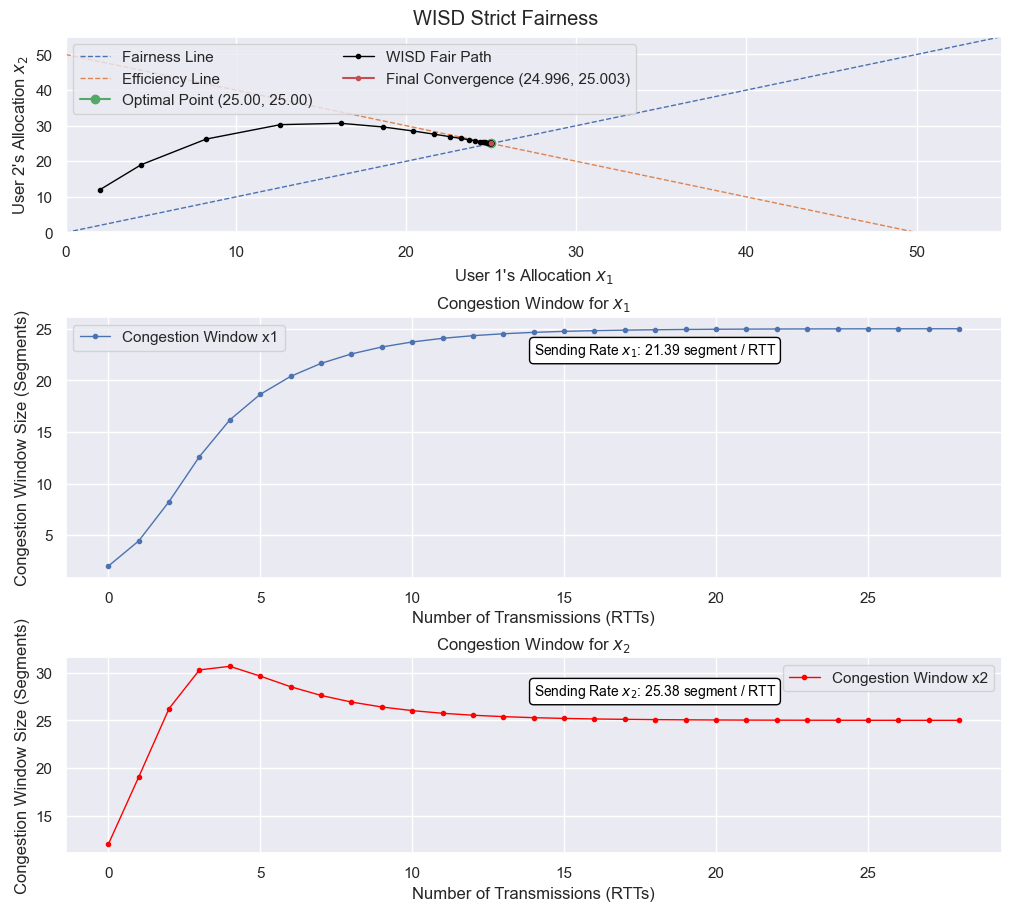

In [57]:
def wisd_plot(C, x1, x2, kappa, fairness_factor, output, title):
    """
    AIMD++: Enforces strict fairness in congestion control by balancing allocations dynamically.

    Args:
        C (int): Maximum capacity.
        x1 (float): Initial allocation for user 1.
        x2 (float): Initial allocation for user 2.
        kappa (float): Controls the rate of decrease (higher = faster reaction).
        fairness_factor (float): Controls fairness enforcement (higher = stronger correction).
        output (str): Filename to save the plot.
        title (str): Main title of the plot.
    """

    sns.set_theme(style="darkgrid")
    x1_values, x2_values = [x1], [x2]

    optimal_x = C / 2
    optimal_y = C / 2
    iterations = 0

    while iterations < 1000:
        if round(x1, 2) == round(optimal_x, 2) and round(x2, 2) == round(optimal_y, 2):
            break

        if (x1 + x2) <= C:
            # **Aggressive Fairness-Aware Increase**
            fairness_correction = fairness_factor * (x2 - x1)
            x1 += ((C - (x1 + x2)) / C) * x1 + fairness_correction
            x2 += ((C - (x1 + x2)) / C) * x2 - fairness_correction
        else:
            # **Balanced Multiplicative Decrease**
            beta = 1 / (1 + np.exp(-kappa * (x1 + x2 - C)))

            # Adjust decrease based on current allocation ratio
            total_allocation = x1 + x2
            weight_x1 = x1 / total_allocation
            weight_x2 = x2 / total_allocation

            x1 *= (1 - beta * (1 + 0.05 * weight_x1))  # Slight penalty for higher allocation
            x2 *= (1 - beta * (1 + 0.05 * weight_x2))

        x1_values.append(x1)
        x2_values.append(x2)
        iterations += 1

    x1_values, x2_values = np.array(x1_values), np.array(x2_values)
    sending_rate_x1 = np.mean(x1_values)
    sending_rate_x2 = np.mean(x2_values)

    print(f'Number of iterations to converge: {iterations}')
    print(f'Final x1: {x1:.2f}')
    print(f'Final x2: {x2:.2f}')

    # Plot WISD Fairness Evolution
    fig = plt.figure(figsize=(10, 9), layout="constrained")

    # Main Trajectory Plot
    main_plot = plt.subplot2grid((10, 2), (0, 0), colspan=2, rowspan=3)
    congestion_x1 = plt.subplot2grid((10, 2), (3, 0), colspan=2, rowspan=4)
    congestion_x2 = plt.subplot2grid((10, 2), (7, 0), colspan=2, rowspan=3)

    # Fairness & Efficiency Lines
    fairness_x = np.linspace(0, C * 1.1, C)
    main_plot.plot(fairness_x, fairness_x, linestyle='dashed', linewidth=1, label='Fairness Line')
    efficiency_x = np.linspace(0, C, C)
    efficiency_y = C - efficiency_x
    main_plot.plot(efficiency_x, efficiency_y, linestyle='dashed', linewidth=1, label='Efficiency Line')

    # Optimal Point
    main_plot.plot(optimal_x, optimal_y, marker='o', label=f'Optimal Point ({optimal_x:.2f}, {optimal_y:.2f})')

    # WISD Algorithm Trajectory
    main_plot.plot(x1_values, x2_values, marker='.', color='black', linewidth=1, label='WISD Fair Path')

    # Final Convergent Point
    main_plot.plot(x1_values[-1], x2_values[-1], marker='.', label=f'Final Convergence ({x1_values[-1]:.3f}, {x2_values[-1]:.3f})')

    # Formatting
    main_plot.set_xlabel("User 1's Allocation $x_{1}$")
    main_plot.set_ylabel("User 2's Allocation $x_{2}$")
    main_plot.set_xlim(0, C * 1.1)
    main_plot.set_ylim(0, C * 1.1)
    main_plot.legend(loc='upper left', ncol=2)

    # RTT Evolution
    rtt_values = np.arange(iterations + 1)

    # User 1 Congestion Window
    congestion_x1.plot(rtt_values, x1_values, marker=".", linewidth=1, label='Congestion Window x1')
    congestion_x1.annotate(
        f'Sending Rate $x_{1}$: {sending_rate_x1:.2f} segment / RTT',
        xy=(iterations / 2, np.max(x1_values) * 0.9),
        fontsize=10, color='black',
        bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3')
    )
    congestion_x1.set_xlabel('Number of Transmissions (RTTs)')
    congestion_x1.set_ylabel('Congestion Window Size (Segments)')
    congestion_x1.set_title('Congestion Window for $x_{1}$')
    congestion_x1.legend()

    # User 2 Congestion Window
    congestion_x2.plot(rtt_values, x2_values, marker=".", linewidth=1, label='Congestion Window x2', color='red')
    congestion_x2.annotate(
        f'Sending Rate $x_{2}$: {sending_rate_x2:.2f} segment / RTT',
        xy=(iterations / 2, np.max(x2_values) * 0.9),
        fontsize=10, color='black',
        bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3')
    )
    congestion_x2.set_xlabel('Number of Transmissions (RTTs)')
    congestion_x2.set_ylabel('Congestion Window Size (Segments)')
    congestion_x2.set_title('Congestion Window for $x_{2}$')
    congestion_x2.legend()

    fig.suptitle(title)

    # Save & Show
    plt.savefig(output)
    plt.show()

wisd_plot(
    C=50,
    x1=2,
    x2=12,
    kappa=0.5,  # Controls reaction speed
    fairness_factor=0.1,  # Stronger fairness enforcement
    output="WISD.svg",
    title="WISD Strict Fairness"
)

## 3.2.2 AI-driven Congestion Control

In [8]:
def get_optimized_aimd_params(c, x1, x2, prev_alpha1, prev_alpha2, prev_beta1, prev_beta2):
    """
    Calls OpenAI API to get optimized AIMD parameters while ensuring fairness and stability.
    """

    prompt = f"""
    You are an AI assistant optimizing TCP congestion control parameters for fairness and stability.
    Your goal is to ensure that x1 and x2 converge towards equal and maximized utilization of the TCP load.

    **STRICT RULES TO FOLLOW:**
    - Maintain the constraint: x1 + x2 ≈ {c} (must not exceed c).
    - Ensure fairness: Adjust x1 and x2 so that they **always** move towards x1 ≈ x2.
    - **x1 must NEVER decrease if x1 < x2** and **x2 must NEVER decrease if x2 < x1**.
    - Under no circumstances should x1 move to the left side of the fairness line (x1 < x2).
    - Adjust alpha1, alpha2 dynamically so that fairness is **strictly followed**.
    - Apply multiplicative decrease to prevent exceeding capacity.
    - Respond **only** with a valid JSON object containing updated AIMD parameters.
    - **DO NOT EXPLAIN** or include extra text.

    **Current State:**
    {{
        "x1": {x1},
        "x2": {x2},
        "alpha1": {prev_alpha1},
        "alpha2": {prev_alpha2},
        "beta1": {prev_beta1},
        "beta2": {prev_beta2}
    }}

    **Expected JSON Response (Example Format):**
    {{
        "alpha1": 0.12,
        "alpha2": 0.14,
        "beta1": 0.45,
        "beta2": 0.48
    }}

    **DO NOT ADD EXPLANATIONS OR ANY EXTRA TEXT. RETURN ONLY A JSON OBJECT.**
    """

    try:
        response = openai.chat.completions.create(
            messages=[
                {"role": "system", "content": "You are a TCP congestion control optimization assistant."},
                {"role": "user", "content": prompt}
            ],
            model="gpt-4o",
        )
        
        # Extract JSON response
        response_text = response.choices[0].message.content.strip()
        cleaned_response = response_text.strip("```json").strip("```").strip()
        print("Cleaned response: ", cleaned_response)
        params = json.loads(cleaned_response)

        return (
            float(params.get("alpha1", prev_alpha1)),
            float(params.get("alpha2", prev_alpha2)),
            float(params.get("beta1", prev_beta1)),
            float(params.get("beta2", prev_beta2)),
        )

    except (json.JSONDecodeError, KeyError, ValueError) as e:
        print("Error in API Response:", e)
        return prev_alpha1, prev_alpha2, prev_beta1, prev_beta2  # Fallback values


def aimd_api_optimized_plot(C, x1, x2, alpha1, alpha2, beta1, beta2, output: str = 'output.svg', title: str = 'AIMD Convergence Algorithm'):
    """
    Visualizes the AIMD (Additive Increase Multiplicative Decrease) process.

    Args:
        C (int): Maximum capacity before multiplicative decrease is applied.
        x1 (int): Initial allocation for user 1.
        x2 (int): Initial allocation for user 2.
        alpha1 (int): Additive increase factor for x1.
        alpha2 (int): Additive increase factor for x2.
        beta1 (int): Multiplicative decrease factor for x1.
        beta2 (int): Multiplicative decrease factor for x2.
        output (str): Filename to save the plot (default: 'output.svg').
        title (str): Main title of the plot.
    """

    # Apply Seaborn dark grid theme
    sns.set_theme(style="darkgrid")

    # Initialize lists to store allocations
    x1_values, x2_values = [x1], [x2]
    
    # Compute the optimal point of convergence
    optimal_x = C / 2
    optimal_y = C / 2

    iterations = 0

    while iterations < 1000:  # Prevent infinite loops
        if round(x1, 2) == round(optimal_x, 2) and round(x2, 2) == round(optimal_y, 2):
            break
        
        alpha1, alpha2, beta1, beta2 = get_optimized_aimd_params(C, x1, x2, alpha1, alpha2, beta1, beta2)
        # Apply Additive Increase if sum is within capacity
        if (x1 + x2) <= C:
            x1 += alpha1
            x2 += alpha2
        else:  # Apply Multiplicative Decrease if sum exceeds capacity
            x1 *= (1 - beta1)
            x2 *= (1 - beta2)

        x1_values.append(x1)
        x2_values.append(x2)
        iterations += 1

    # Convert lists to NumPy arrays for easier plotting
    x1_values, x2_values = np.array(x1_values), np.array(x2_values)

    # Compute average sending rates
    sending_rate_x1 = np.mean(x1_values)
    sending_rate_x2 = np.mean(x2_values)

    print(f'Number of iterations to converge: {iterations}')
    print(f'Final x1: {x1:.2f}')
    print(f'Final x2: {x2:.2f}')

    # Adjust figure layout to make congestion graphs bigger
    fig = plt.figure(figsize=(10, 9), layout="constrained")  # Increased figure size

    # Create subplots with adjusted row spans for bigger congestion graphs
    main_plot = plt.subplot2grid((10, 2), (0, 0), colspan=2, rowspan=3)  # Reduced height of main plot
    congestion_x1 = plt.subplot2grid((10, 2), (3, 0), colspan=2, rowspan=4)  # Increased height
    congestion_x2 = plt.subplot2grid((10, 2), (7, 0), colspan=2, rowspan=3)  # Increased height

    # Fairness Line (x1 = x2)
    fairness_x = np.linspace(0, C * 1.1, C)
    main_plot.plot(fairness_x, fairness_x, linestyle='dashed', linewidth=1, label='Fairness Line')

    # Efficiency Line (x1 + x2 = C)
    efficiency_x = np.linspace(0, C, C)
    efficiency_y = C - efficiency_x
    main_plot.plot(efficiency_x, efficiency_y, linestyle='dashed', linewidth=1, label='Efficiency Line')

    # Optimal Point
    main_plot.plot(optimal_x, optimal_y, marker='o', label=f'Optimal Point ({optimal_x:.2f}, {optimal_y:.2f})')

    # AIMD Algorithm Trajectory
    main_plot.plot(x1_values, x2_values, marker='.', color='black', linewidth=1, label='AIMD Path')

    # Final Convergent Point
    main_plot.plot(x1_values[-1], x2_values[-1], marker='.', label=f'Final Convergence ({x1_values[-1]:.3f}, {x2_values[-1]:.3f})')

    # Labels & Formatting
    main_plot.set_xlabel("User 1's Allocation $x_{1}$")
    main_plot.set_ylabel("User 2's Allocation $x_{2}$")
    main_plot.set_xlim(0, C * 1.1)
    main_plot.set_ylim(0, C * 1.1)
    main_plot.legend(loc='upper left', ncol=2)

    # RTT (Round-Trip Time) values
    rtt_values = np.arange(iterations + 1)

    # Congestion Window for x1
    congestion_x1.plot(rtt_values, x1_values, marker=".", linewidth=1, label='Congestion Window x1')
    congestion_x1.annotate(
        f'Sending Rate $x_{1}$: {sending_rate_x1:.2f} segment / RTT',
        xy=(iterations / 2, np.max(x1_values) * 0.9),
        fontsize=10, color='black',
        bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3')
    )
    congestion_x1.set_xlabel('Number of Transmissions (RTTs)')
    congestion_x1.set_ylabel('Congestion Window Size (Segments)')
    congestion_x1.set_title('Congestion Window for $x_{1}$')
    congestion_x1.legend()

    # Congestion Window for x2
    congestion_x2.plot(rtt_values, x2_values, marker=".", linewidth=1, label='Congestion Window x2', color='red')
    congestion_x2.annotate(
        f'Sending Rate $x_{2}$: {sending_rate_x2:.2f} segment / RTT',
        xy=(iterations / 2, np.max(x2_values) * 0.9),
        fontsize=10, color='black',
        bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3')
    )
    congestion_x2.set_xlabel('Number of Transmissions (RTTs)')
    congestion_x2.set_ylabel('Congestion Window Size (Segments)')
    congestion_x2.set_title('Congestion Window for $x_{2}$')
    congestion_x2.legend()

    fig.suptitle(title)

    # Save and show the plot
    plt.savefig(output)
    plt.show()

Cleaned response:  {
    "alpha1": 2,
    "alpha2": 0,
    "beta1": 0.5,
    "beta2": 0.5
}
Cleaned response:  {
    "alpha1": 2.0,
    "alpha2": 2.0,
    "beta1": 0.5,
    "beta2": 0.5
}
Cleaned response:  {
    "alpha1": 2.0,
    "alpha2": 0.5,
    "beta1": 0.5,
    "beta2": 0.5
}
Cleaned response:  {
    "alpha1": 0.2,
    "alpha2": 0.5,
    "beta1": 0.6,
    "beta2": 0.5
}
Cleaned response:  {
    "alpha1": 0.3,
    "alpha2": 0.2,
    "beta1": 0.6,
    "beta2": 0.5
}
Cleaned response:  {
    "alpha1": 0.35,
    "alpha2": 0.2,
    "beta1": 0.6,
    "beta2": 0.5
}
Cleaned response:  {
    "alpha1": 0.4,
    "alpha2": 0.1,
    "beta1": 0.6,
    "beta2": 0.5
}
Cleaned response:  {
    "alpha1": 0.1,
    "alpha2": 0.4,
    "beta1": 0.6,
    "beta2": 0.5
}
Cleaned response:  {
    "alpha1": 0.4,
    "alpha2": 0.1,
    "beta1": 0.6,
    "beta2": 0.5
}
Cleaned response:  {
    "alpha1": 0.25,
    "alpha2": 0.05,
    "beta1": 0.6,
    "beta2": 0.6
}
Cleaned response:  {
    "alpha1": 0.1,
 

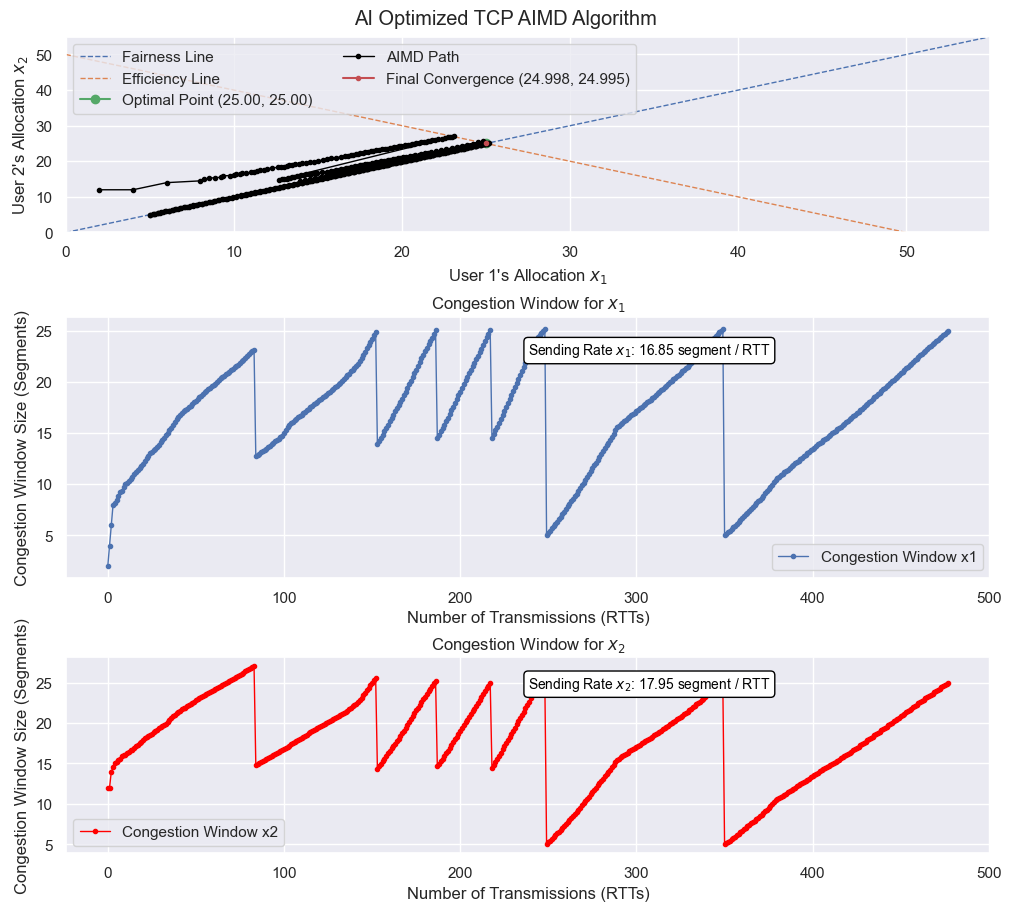

In [10]:
aimd_api_optimized_plot(C=50,
          x1=2,
          x2=12,
          alpha1=1,
          alpha2=1,
          beta1=0.5,
          beta2=0.5,
          output=f"AIMD_AI.svg",
          title="AI Optimized TCP AIMD Algorithm"
          )